In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import scipy
import numpy as np
import matplotlib.pyplot as plt

import celeri

plt.rcParams["text.usetex"] = False

In [4]:
# TODO: CHANGE THIS to 1/ 1e3

DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# NOTE: This modification of the number of eigenvalues is for experiments
meshes[0].n_modes_strike_slip = 10
meshes[0].n_modes_dip_slip = 50

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-07-12 14:11:40.477 | INFO     | celeri.celeri:get_logger:6343 - Read: ../data/command/western_north_america_command.json
2024-07-12 14:11:40.477 | INFO     | celeri.celeri:get_logger:6344 - RUN_NAME: 0000000013
2024-07-12 14:11:40.478 | INFO     | celeri.celeri:get_logger:6345 - Write log file: ../runs/0000000013/0000000013.log
2024-07-12 14:11:40.478 | INFO     | celeri.celeri:read_data:302 - Reading data files
2024-07-12 14:11:40.484 | SUCCESS  | celeri.celeri:read_data:306 - Read: ../data/segment/western_north_america_segment.csv
2024-07-12 14:11:40.486 | SUCCESS  | celeri.celeri:read_data:311 - Read: ../data/block/western_north_america_block.csv
2024-07-12 14:11:40.487 | SUCCESS  | celeri.celeri:read_data:318 - Read: ../data/mesh/western_north_america_mesh_parameters.json

2024-07-12 14:11:40.599 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/cascadia.msh
2024-07-12 14:11:40.602 | SUCCESS  | celeri.celeri:read_data:500 - Read: ../data/station/western_north_ameri

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-07-12 14:11:41.333 | INFO     | celeri.celeri:get_elastic_operators:1687 - Using precomputed elastic operators
2024-07-12 14:11:41.919 | INFO     | celeri.celeri:get_slip_rate_constraints:2918 - Found 1 slip rate constraints
2024-07-12 14:11:41.923 | INFO     | celeri.celeri:get_slip_rate_constraints:2921 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# 1. Full direct dense block model solve


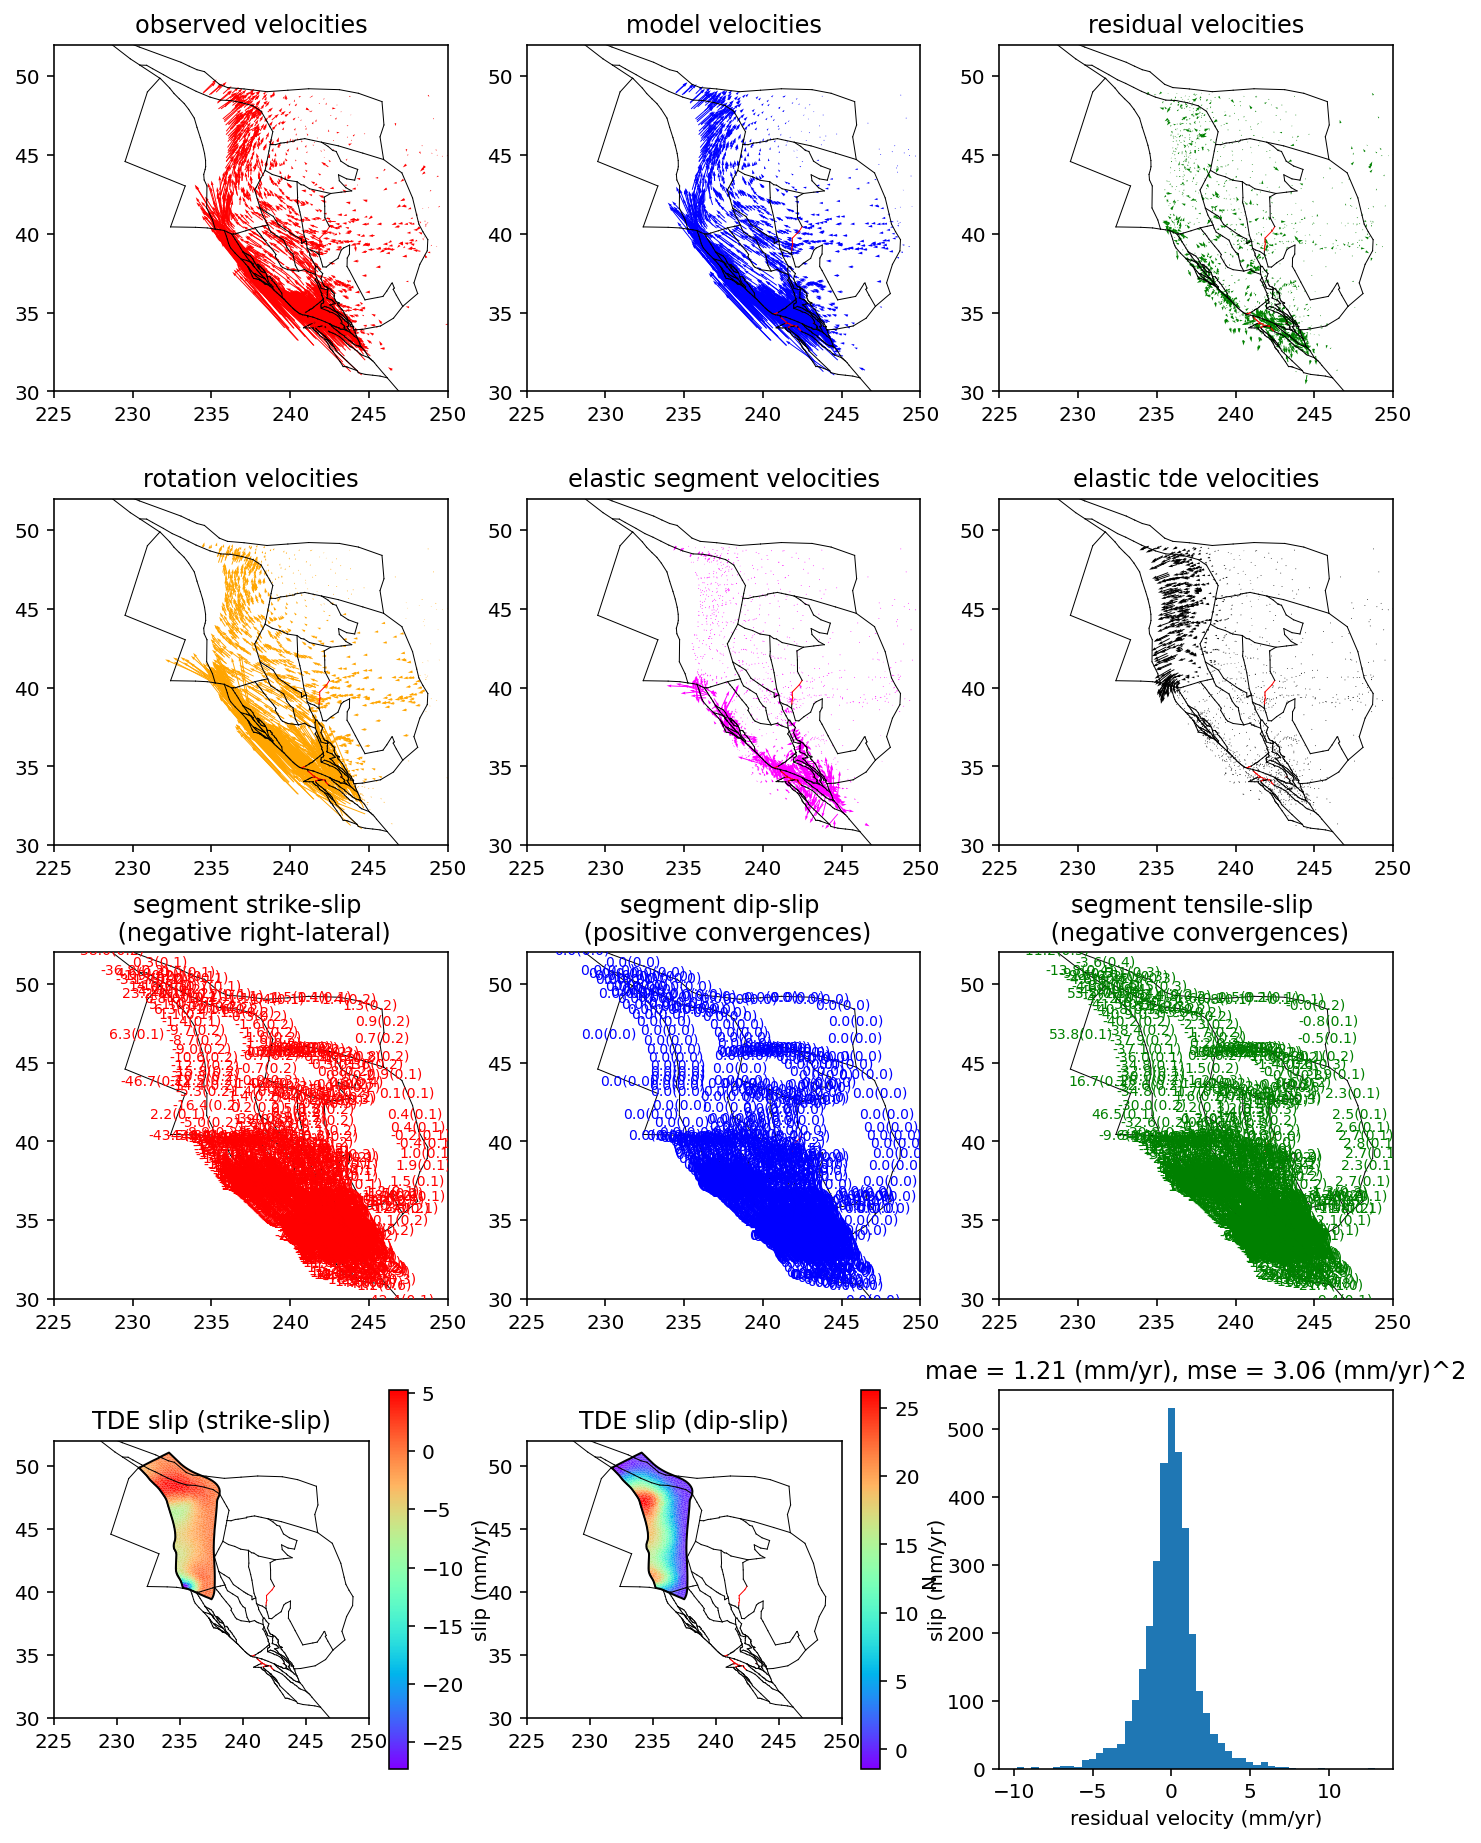

2024-07-12 14:11:51.559 | SUCCESS  | celeri.celeri:plot_estimation_summary:5553 - Wrote figures../runs/0000000013/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [6]:
index = celeri.get_index(assembly, station, block, meshes, mogi)
estimation = addict.Dict()
estimation.data_vector = celeri.get_data_vector(assembly, index, meshes)
estimation.weighting_vector = celeri.get_weighting_vector(
    command, station, meshes, index
)
estimation.operator = celeri.get_full_dense_operator(operators, meshes, index)

# Solve the overdetermined linear system
estimation.state_covariance_matrix = np.linalg.inv(
    estimation.operator.T * estimation.weighting_vector @ estimation.operator
)
estimation.state_vector = (
    estimation.state_covariance_matrix
    @ estimation.operator.T
    * estimation.weighting_vector
    @ estimation.data_vector
)

celeri.post_process_estimation(estimation, operators, station, index)
# celeri.write_output(command, estimation, station, segment, block, meshes)

celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# KL machinery (panel)

In [7]:
def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z, distance_exponent):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-(distance_matrix**distance_exponent))
    # correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


# Calculate eigenvales and eigenvectors for triangle subset
# NOTE: Set n_modes to the great of strike-slip or dip slip modes
# This overrides n_modes in mesh files
meshes[0].n_modes = np.max([meshes[0].n_modes_strike_slip, meshes[0].n_modes_dip_slip])

eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
    meshes[0].n_modes,
    meshes[0].x_centroid,
    meshes[0].y_centroid,
    meshes[0].z_centroid,
    distance_exponent=1.0,
)


# TODO: Push to function
# Create eigenmodes to TDE slip matrix (panel style)
eigenvectors_two_component = np.zeros(
    (
        2 * eigenvectors.shape[0],
        meshes[0].n_modes_strike_slip + meshes[0].n_modes_dip_slip,
    )
)

eigenvectors_two_component[0::2, 0 : meshes[0].n_modes_strike_slip] = eigenvectors[
    :, 0 : meshes[0].n_modes_strike_slip
]
eigenvectors_two_component[
    1::2,
    meshes[0].n_modes_strike_slip : meshes[0].n_modes_strike_slip
    + meshes[0].n_modes_dip_slip,
] = eigenvectors[:, 0 : meshes[0].n_modes_dip_slip]


def get_data_vector_eigen(assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_smoothing_row[i] : index.start_tde_smoothing_row[i]
            + index.n_tde_constraints[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator

    n_eigen = eigenvectors_two_component.shape[1] / 2
    print(f"{n_eigen=}")

    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            + index.n_tde_constraints_total,
            3 * index.n_blocks + 2 * int(n_eigen),
        )
    )
    print(f"{eigenvectors_two_component.shape=}")
    print(f"{operator.shape=}")

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # Insert eigenvector to velocity matrix
    # TODO: Generalize over multiple meshes
    # Eliminate vertical elastic velocities
    tde_keep_row_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[0]
    )
    tde_keep_col_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[1]
    )
    eigen_to_velocities = (
        -operators.tde_to_velocities[0][tde_keep_row_index, :][:, tde_keep_col_index]
        @ eigenvectors_two_component
    )

    # TODO: Update index here with eigen specific terms
    # TODO: Generalize over multiple meshes
    operator[
        index.start_station_row : index.end_station_row,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_modes,
    ] = eigen_to_velocities

    # Insert eigenvector to TDE constraints matrix
    # TODO: Generalize over multiple meshes
    print(meshes[0].mesh_tde_modes_bc_weight)
    eigen_to_tde_slip_rate_constraints = (
        meshes[0].mesh_tde_modes_bc_weight
        * operators.tde_slip_rate_constraints[0]
        @ eigenvectors_two_component
    )

    operator[
        index.start_slip_rate_constraints_row : index.start_slip_rate_constraints_row
        + index.n_tde_constraints_total,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_modes,
    ] = eigen_to_tde_slip_rate_constraints

    # # Insert TDE to velocity matrix
    # for i in range(len(meshes)):
    #     # Insert TDE to velocity matrix
    #     tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    #     tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    #     operator[
    #         index.start_station_row : index.end_station_row,
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = -operators.tde_to_velocities[i][tde_keep_row_index, :][
    #         :, tde_keep_col_index
    #     ]

    #     # # Insert TDE smoothing matrix
    #     # smoothing_keep_index = celeri.get_keep_index_12(
    #     #     operators.tde_to_velocities[i].shape[1]
    #     # )
    #     # operator[
    #     #     index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i],
    #     #     index.start_tde_col[i] : index.end_tde_col[i],
    #     # ] = operators.smoothing_matrix[i].toarray()[smoothing_keep_index, :][
    #     #     :, smoothing_keep_index
    #     # ]

    #     # Insert TDE slip rate constraints into estimation operator
    #     operator[
    #         index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i],
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = operators.tde_slip_rate_constraints[i]
    return operator


data_vector = celeri.get_data_vector(assembly, index, meshes)
data_vector_eigen = get_data_vector_eigen(assembly, index)
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operator = celeri.get_full_dense_operator(operators, meshes, index)
operator_eigen = get_full_dense_operator_eigen(operators, meshes, index)


def post_process_estimation_eigen(estimation_eigen, operators, station, index):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    estimation_eigen.eigenvalues = estimation_eigen.state_vector[3 * n_blocks : :]
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    estimation_eigen.slip_rate_sigma = np.sqrt(
        np.diag(
            operators.rotation_to_slip_rate
            @ estimation_eigen.state_covariance_matrix[
                0 : 3 * index.n_blocks, 0 : 3 * index.n_blocks
            ]
            @ operators.rotation_to_slip_rate.T
        )
    )  # I don't think this is correct because for the case when there is a rotation vector a priori
    estimation_eigen.strike_slip_rate_sigma = estimation_eigen.slip_rate_sigma[0::3]
    estimation_eigen.dip_slip_rate_sigma = estimation_eigen.slip_rate_sigma[1::3]
    estimation_eigen.tensile_slip_rate_sigma = estimation_eigen.slip_rate_sigma[2::3]

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = (
        eigenvectors_two_component @ estimation_eigen.state_vector[3 * n_blocks : :]
    )

    # Old checkerboard
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # TODO: Generalize over multiple meshes

    # # New panel checkerboard
    # estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[
    #     0 :: meshes[0].n_tde
    # ]
    # estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[
    #     meshes[0].n_tde : :
    # ]

    # Create a pseudo state vector that is the length of a TDE state vector
    estimation_eigen.pseudo_tde_state_vector = np.zeros(
        3 * n_blocks + 2 * index.n_tde_total
    )
    estimation_eigen.pseudo_tde_state_vector[0 : 3 * index.n_blocks] = (
        estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks : :] = (
        estimation_eigen.tde_rates
    )

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):

        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )
        estimation_eigen.vel_tde += (
            operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
            @ eigenvectors_two_component
            @ estimation_eigen.state_vector[
                index.start_tde_col[i] : index.end_tde_col[i]
            ]
            # @ estimation_eigen.eigenvalues
        )
    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]

n_eigen=30.0
eigenvectors_two_component.shape=(3682, 60)
operator.shape=(3519, 153)
10.0


# 4. Bounded with different modes

In [37]:
# Get total number of modes
n_modes_total = 0
for i in range(len(meshes)):
    n_modes_total += meshes[i].n_modes_strike_slip
    n_modes_total += meshes[i].n_modes_dip_slip

# TODO: Add strain elements
n_strain_blocks = np.sum(np.where(block.strain_rate_flag == 1)[0])
n_mogi = len(mogi)
n_state_vector_eigen = 3 * n_blocks + n_modes_total + n_mogi + n_strain_blocks

(7364, 153)
(3682, 60)
     pcost       dcost       gap    pres   dres
 0: -4.7490e+08 -4.7616e+08  2e+06  1e-01  8e-17
 1: -4.7491e+08 -4.7524e+08  3e+05  2e-02  2e-18
 2: -4.7491e+08 -4.7519e+08  3e+05  1e-02  2e-18
 3: -4.7491e+08 -4.7515e+08  3e+05  7e-03  1e-18
 4: -4.7491e+08 -4.7509e+08  2e+05  2e-03  1e-18
 5: -4.7491e+08 -4.7495e+08  4e+04  2e-16  3e-18
 6: -4.7491e+08 -4.7492e+08  1e+04  2e-16  6e-19
 7: -4.7491e+08 -4.7492e+08  5e+03  2e-16  1e-18
 8: -4.7491e+08 -4.7492e+08  2e+03  2e-16  2e-18
 9: -4.7491e+08 -4.7491e+08  2e+03  2e-16  1e-18
10: -4.7491e+08 -4.7491e+08  1e+03  2e-16  3e-18
11: -4.7491e+08 -4.7491e+08  6e+02  2e-16  2e-18
12: -4.7491e+08 -4.7491e+08  2e+02  2e-16  3e-18
Optimal solution found.


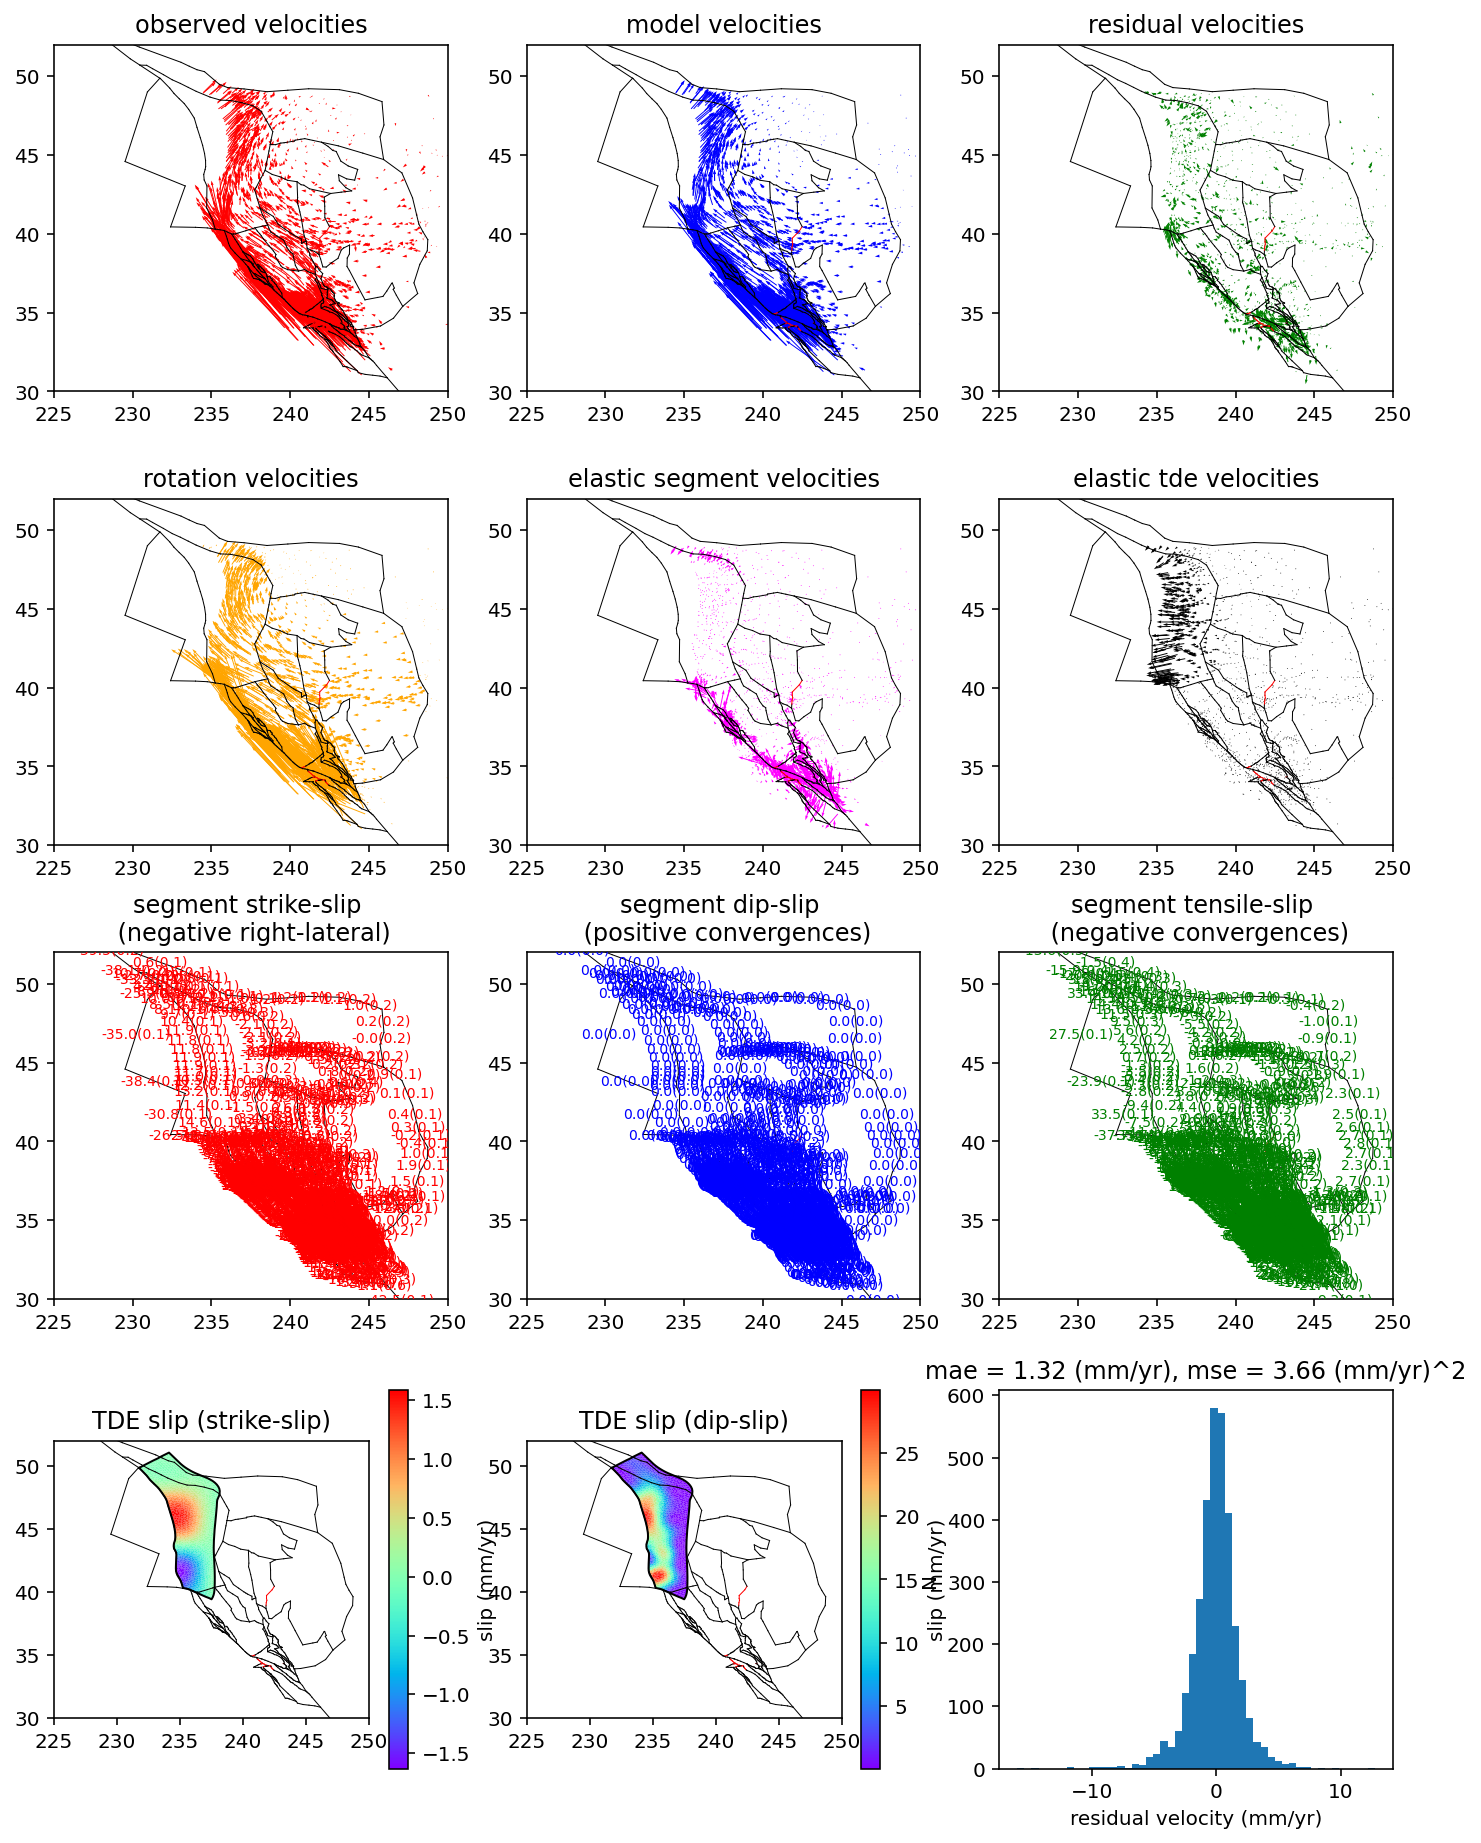

2024-07-12 15:04:31.613 | SUCCESS  | celeri.celeri:plot_estimation_summary:5553 - Wrote figures../runs/0000000013/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [28]:
# Options dictionary for lsqlin_qp
opts = {"show_progress": True}

lower_bound = -np.ones_like(estimation.state_vector)
upper_bound = np.ones_like(estimation.state_vector)

# TDE strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# TDE dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

lower_bound_tde_only = lower_bound[3 * n_blocks : :]
upper_bound_tde_only = upper_bound[3 * n_blocks : :]

A = np.zeros((2 * eigenvectors_two_component.shape[0], n_state_vector_eigen))
A[0 : eigenvectors_two_component.shape[0], 3 * n_blocks :] = -eigenvectors_two_component
A[eigenvectors_two_component.shape[0] :, 3 * n_blocks :] = eigenvectors_two_component

# Try sparse version of constraint matrix
# A = scipy.sparse.csr_matrix(A)

# TODO: Need better use of index for shape here
b = np.zeros(2 * eigenvectors_two_component.shape[0])
b[0 : eigenvectors_two_component.shape[0]] = -lower_bound_tde_only
b[eigenvectors_two_component.shape[0] :] = upper_bound_tde_only


# TODO: Better name for ret
ret = celeri.lsqlin_qp(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    A,  # A=None, inequality operator
    b,  # b=None, inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)

estimation_eigen_cvxopt_bounded = addict.Dict()
estimation_eigen_cvxopt_bounded.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_cvxopt_bounded.state_vector = np.array(ret["x"]).flatten()
forward_data_vector_eigen = (
    operator_eigen @ estimation_eigen_cvxopt_bounded.state_vector
)
estimation_eigen_cvxopt_bounded.operator = operator_eigen
post_process_estimation_eigen(
    estimation_eigen_cvxopt_bounded, operators, station, index
)

celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen_cvxopt_bounded,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [38]:
np.savez(
    "test_eigen_arrays.npz",
    estimation_eigen_cvxopt_bounded_slip_rates=estimation_eigen_cvxopt_bounded.slip_rates,
    estimation_eigen_cvxopt_bounded_tde_rates=estimation_eigen_cvxopt_bounded.tde_rates,
    estimation_eigen_cvxopt_bounded_east_vel_residual=estimation_eigen_cvxopt_bounded.east_vel_residual,
    estimation_eigen_cvxopt_bounded_north_vel_residual=estimation_eigen_cvxopt_bounded.north_vel_residual,
)

testing_eigen_arrays = np.load("test_eigen_arrays.npz")
assert np.allclose(
    estimation_eigen_cvxopt_bounded.slip_rates,
    testing_eigen_arrays["estimation_eigen_cvxopt_bounded_slip_rates"],
)
assert np.allclose(
    estimation_eigen_cvxopt_bounded.tde_rates,
    testing_eigen_arrays["estimation_eigen_cvxopt_bounded_tde_rates"],
)
assert np.allclose(
    estimation_eigen_cvxopt_bounded.east_vel_residual,
    testing_eigen_arrays["estimation_eigen_cvxopt_bounded_east_vel_residual"],
)
assert np.allclose(
    estimation_eigen_cvxopt_bounded.north_vel_residual,
    testing_eigen_arrays["estimation_eigen_cvxopt_bounded_north_vel_residual"],
)

# Add slip rate constraint

In [ ]:
# Currently reusing one of the fault elements that has an apriori
# Linear inequality constraint for the sign of one slip rate

# TODO: A new version of:
# def get_slip_rate_constraints(assembly, segment, block, command):
#
# Actually this:
# slip_rate_constraint_partials = get_rotation_to_slip_rate_partials(segment, block)
# Just make a dummy segment dictionary?


AA = np.zeros((1, A.shape[1]))
AA[0, 0 : 3 * n_blocks] = -operators.slip_rate_constraints
bb = np.zeros(1)

# New linear total inequality matrix and vector
AAA = np.vstack((A, AA))
bbb = np.hstack((b, bb))

     pcost       dcost       gap    pres   dres
 0: -4.7490e+08 -4.7616e+08  9e+06  3e+00  1e-08
 1: -4.7191e+08 -4.7576e+08  1e+07  2e+00  6e-09
 2: -4.7296e+08 -4.7611e+08  5e+06  4e-01  1e-09
 3: -4.7352e+08 -4.7463e+08  1e+06  3e-02  9e-11
 4: -4.7358e+08 -4.7447e+08  1e+06  2e-02  5e-11
 5: -4.7361e+08 -4.7434e+08  7e+05  5e-03  2e-11
 6: -4.7363e+08 -4.7403e+08  4e+05  6e-04  2e-12
 7: -4.7363e+08 -4.7391e+08  3e+05  4e-04  1e-12
 8: -4.7364e+08 -4.7375e+08  1e+05  1e-04  4e-13
 9: -4.7364e+08 -4.7375e+08  1e+05  1e-04  4e-13
10: -4.7364e+08 -4.7371e+08  7e+04  6e-05  2e-13
11: -4.7364e+08 -4.7367e+08  3e+04  3e-07  1e-15
12: -4.7364e+08 -4.7366e+08  2e+04  1e-07  5e-16
13: -4.7364e+08 -4.7365e+08  1e+04  2e-16  4e-18
14: -4.7364e+08 -4.7365e+08  3e+03  2e-16  2e-18
15: -4.7364e+08 -4.7365e+08  3e+03  2e-16  1e-18
16: -4.7364e+08 -4.7365e+08  1e+03  2e-16  3e-18
17: -4.7364e+08 -4.7364e+08  1e+03  2e-16  4e-18
18: -4.7364e+08 -4.7364e+08  6e+02  2e-16  5e-18
19: -4.7364e+08 -4.73

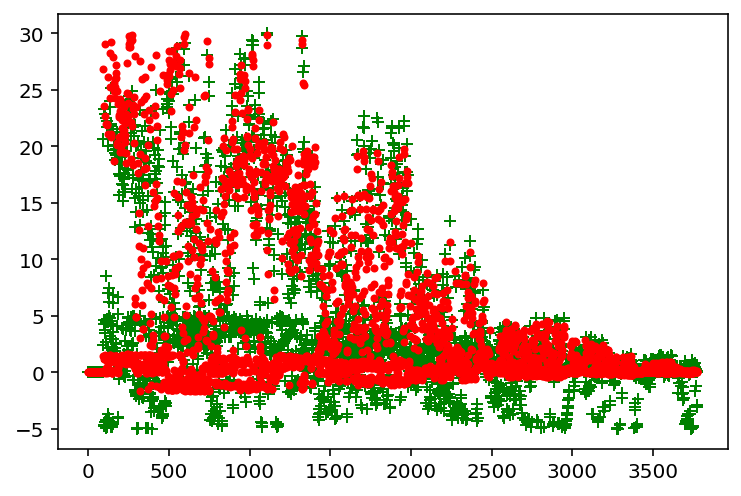

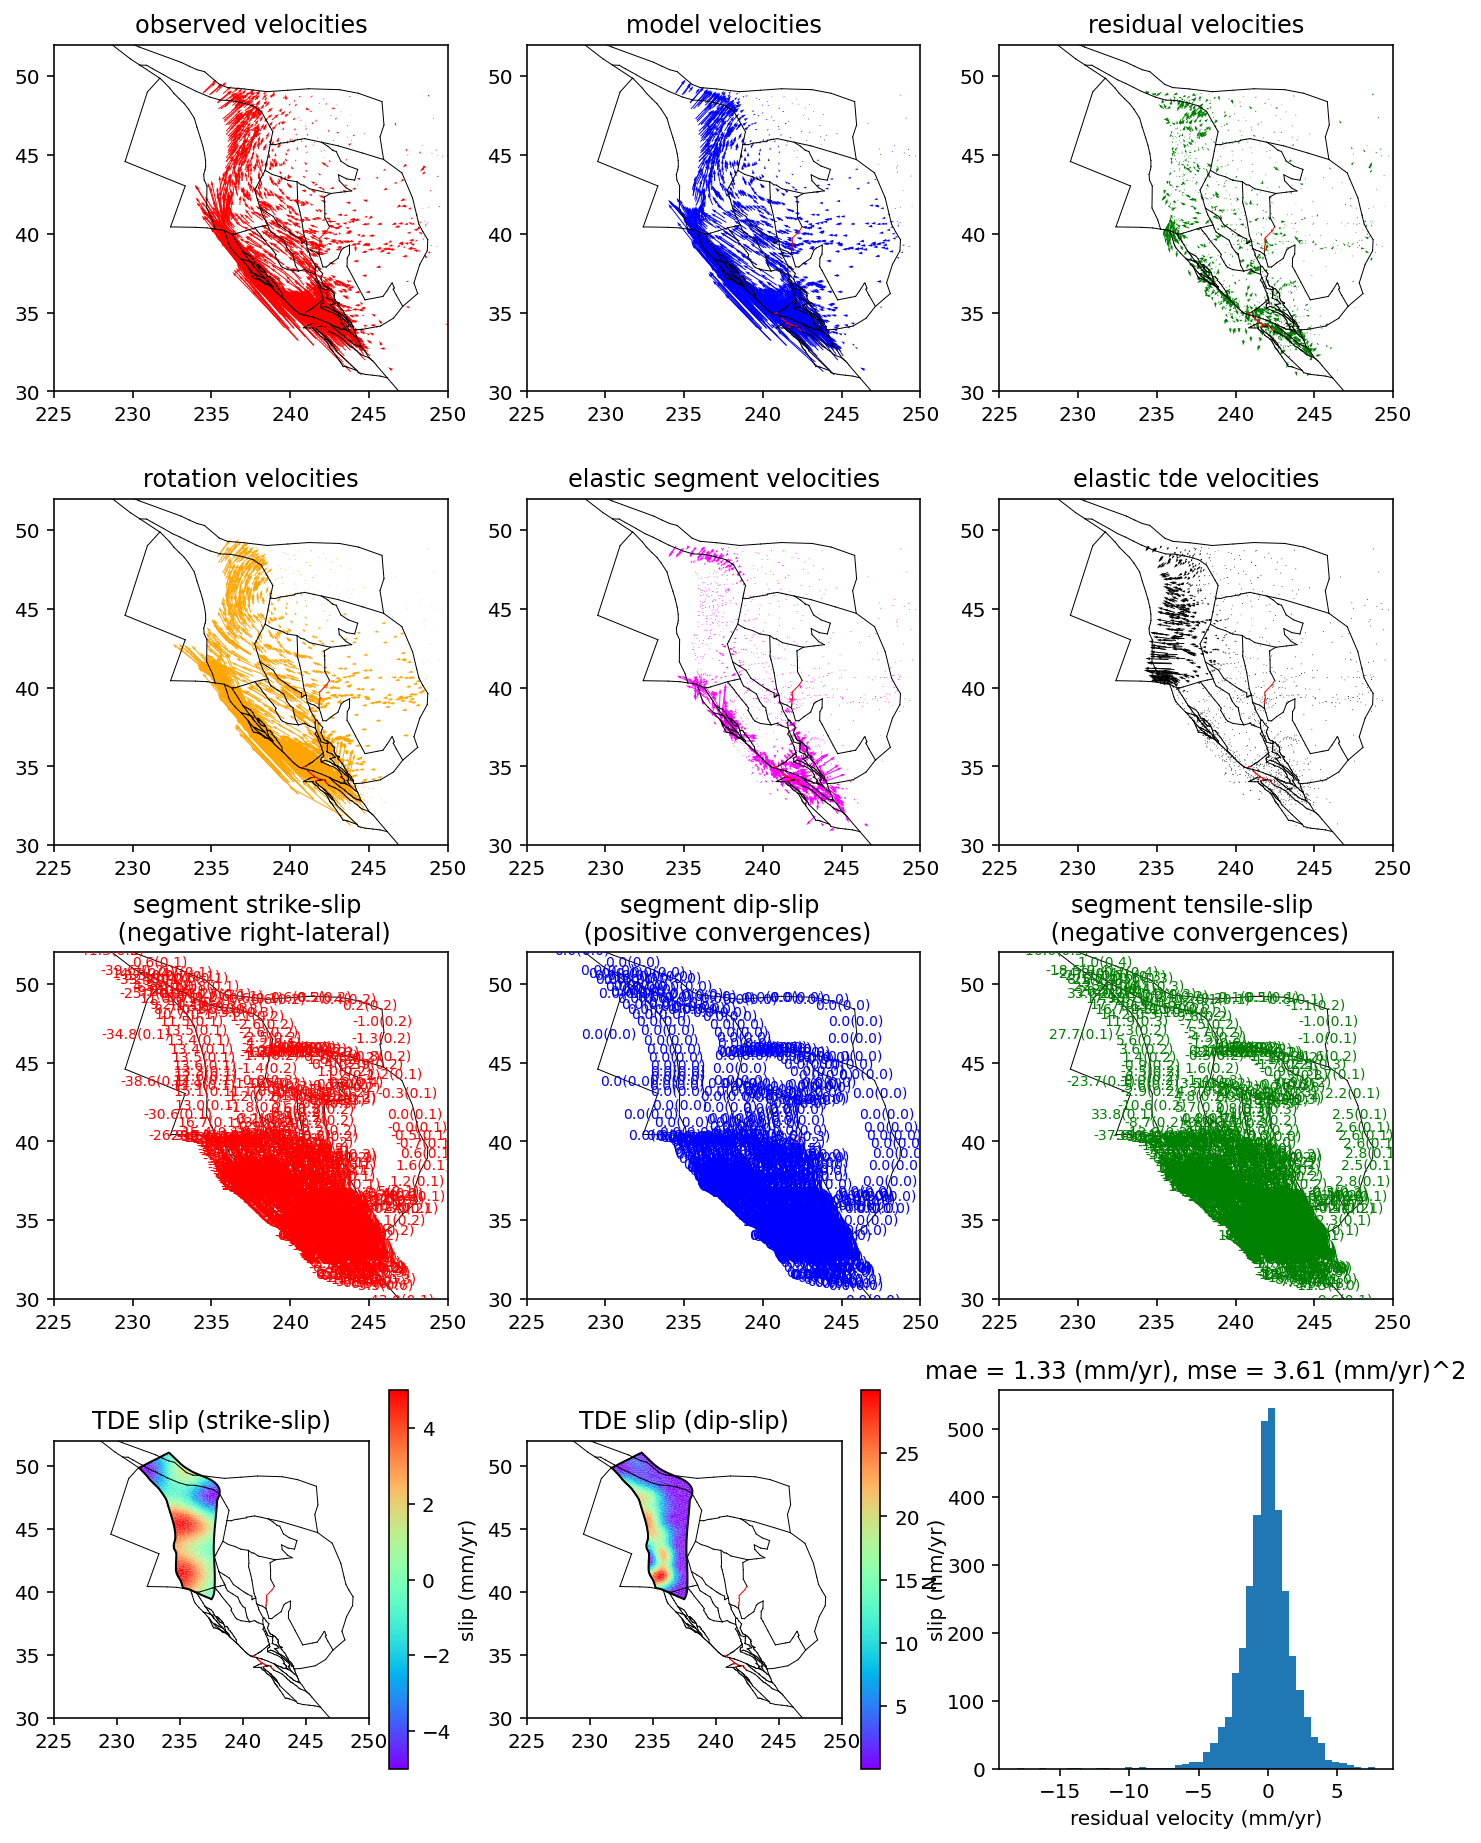

2024-07-12 13:42:36.070 | SUCCESS  | celeri.celeri:plot_estimation_summary:5553 - Wrote figures../runs/0000000012/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [ ]:
ret = celeri.lsqlin_qp(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    AAA,  # A=None, inequality operator
    bbb,  # b=None, inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)

estimation_eigen_cvxopt_bounded_slip_rate = addict.Dict()
estimation_eigen_cvxopt_bounded_slip_rate.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_cvxopt_bounded_slip_rate.state_vector = np.array(ret["x"]).flatten()
forward_data_vector_eigen = (
    operator_eigen @ estimation_eigen_cvxopt_bounded.state_vector
)
estimation_eigen_cvxopt_bounded_slip_rate.operator = operator_eigen
post_process_estimation_eigen(
    estimation_eigen_cvxopt_bounded_slip_rate, operators, station, index
)

plt.figure()
plt.plot(estimation_eigen_cvxopt_bounded_slip_rate.pseudo_tde_state_vector, "g+")
plt.plot(
    estimation_eigen_cvxopt_bounded.pseudo_tde_state_vector,
    "r.",
)
plt.show()

celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen_cvxopt_bounded_slip_rate,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Adding eigen specific values to `index`

In [ ]:
def update_index_eigen(index, meshes):
    index.eigen_start_tde_constraint_row = np.zeros(len(meshes), dtype=int)
    index.eigen_end_tde_constraint_row = np.zeros(len(meshes), dtype=int)
    index.eigen_start_tde_constraint_row[0] = index.end_slip_rate_constraints_row
    index.eigen_end_tde_constraint_row[0] = (
        index.eigen_start_tde_constraint_row[0] + index.n_tde_constraints[0]
    )
    # Starting at 1 because the 0 case is already done (above)
    for i in range(1, len(meshes)):
        index.eigen_start_tde_constraint_row[i] = index.eigen_end_tde_constraint_row[
            i - 1
        ]
        index.eigen_end_tde_constraint_row[i] = (
            index.eigen_start_tde_constraint_row[i - 1] + index.n_tde_constraints[i]
        )


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector_eigen = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Velocity uncertainties
    weighting_vector_eigen[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    # Soft prior block rotation weights
    weighting_vector_eigen[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    # Soft prior slip rate weights
    weighting_vector_eigen[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    # Soft prior TDE weights
    for i in range(len(meshes)):
        weighting_vector_eigen[
            index.eigen_start_tde_constraint_row[i] : index.end_tde_constraint_row[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])
    return weighting_vector_eigen


update_index_eigen(index, meshes)
wve = get_weighting_vector_eigen(command, station, meshes, index)
np.allclose(weighting_vector_eigen, wve)

True

In [36]:
n_strain_blocks = np.sum(np.where(block.strain_rate_flag == 1)[0])

0

In [ ]:
np.